<center>&copy; | Ghassen <strong>MARRAKCHI</strong> - 2022</center>

<img src="../__src/Institut_Galilee.png" style="">
<hr>

<h1 style="text-align:center;color:#5a84ba"><center>Méthodes Matricielles pour le Data Mining</center></h1>
<h2><center><strong><font color='#3f4a4f'>Factorisation Matricielle Non-Négative pour
le Text Mining
</font></strong></center></h2>

<hr>
<h3><center><strong><font color='#3f4a4f'>IV- NMF</font></strong></center></h3>
<hr>

<h4><strong><font color='#353b38'>Plan de Travail</font></strong></h4>

<ol style="list-style-type: upper-roman;">
    <li><a href="./I-Introduction.ipynb">Introduction</a></li>
    <li><a href="./II-Pré-traitemnt du dataset.ipynb">Pré-traitemnt du dataset</a></li>
    <li><a href="./III-Clustering simple.ipynb">Clustering simple</a></li>
    <li><strong>NMF</strong></li>
    <li><a href="./V-Orthogonal NMF.ipynb">Orthogonal NMF</a></li>
    <li><a href="./VI-Symmetric NMF.ipynb">Symmetric NMF</a></li>
    <li><a href="./VII-Conclusion.ipynb">Conclusion</a></li>
</ol>

<hr>
<h4><strong><font color='#353b38'>Objectif</font></strong></h4>

- Application de la NMF

<h4><strong><font color='#353b38'>Configuration générale du notebook</font></strong></h4>

In [1]:
# Packages Importation
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn import metrics
from scipy.special import rel_entr
from itertools import combinations
from math import ceil

In [2]:
# Files Paths


## PLOTS 2D
IV_NMF_2D_H_TEST_PNG = os.path.join('..', 'plots', 'IV-NMF', 'h_test_2D.png')
IV_NMF_2D_H_TEST_JPG = os.path.join('..', 'plots', 'IV-NMF', 'h_test_2D.jpg')
IV_NMF_2D_H_TEST_PDF = os.path.join('..', 'plots', 'IV-NMF', 'h_test_2D.pdf')


## PLOTS 3D
IV_NMF_3D_H_TEST_PNG = os.path.join('..', 'plots', 'IV-NMF', 'h_test_3D.png')
IV_NMF_3D_H_TEST_JPG = os.path.join('..', 'plots', 'IV-NMF', 'h_test_3D.jpg')
IV_NMF_3D_H_TEST_PDF = os.path.join('..', 'plots', 'IV-NMF', 'h_test_3D.pdf')


## CLUSTERING-SIMPLE
CLUST_SIMP_REUT_TRAIN = os.path.join('..', 'dataset', 'III-Clustering_simple', 'reut_train.csv')
CLUST_SIMP_LABELS_TRAIN  = os.path.join('..', 'dataset', 'III-Clustering_simple', 'labels_train.csv')

CLUST_SIMP_REUT_TEST = os.path.join('..', 'dataset', 'III-Clustering_simple', 'reut_test.csv')
CLUST_SIMP_LABELS_TEST  = os.path.join('..', 'dataset', 'III-Clustering_simple', 'labels_test.csv')


## NMF
NMF_W_TRAIN = os.path.join('..', 'dataset', 'IV-NMF', 'w_train.csv')
NMF_H_PARTITION = os.path.join('..', 'dataset', 'IV-NMF', 'h_partition.csv')
NMF_I = os.path.join('..', 'dataset', 'IV-NMF', 'I.csv')

NMF_H_TEST = os.path.join('..', 'dataset', 'IV-NMF', 'h_test.csv')

<h4><strong><font color='#353b38'>Implémentation des fonctions</font></strong></h4>

<h5 id="print_numpy_array_infos">print_numpy_array_infos</h5>

In [3]:
def print_numpy_array_infos(array, name) :
    """ Prints numpy array informations.
    
    Parameters
    ----------
    array : numpy.ndarray
        The array to print its informations
    name : str
        The name to be used for a formatted printing
    """
    
    print("ARRAY : ", name)
    print("--- Type               : ", type(array))
    print("--- Dimensions         : ", array.shape)
    print("--- Nombre de lignes   : ", array.shape[0])
    print("--- Nombre de colonnes : ", array.shape[1])
    print("--- Nombre totale des données décrites dans le dataset : ", array.size)
    print("--- Type des données : ", array.dtype)

    print("\n")

    print("AFFICHAGE (partie) : \n", array[:5,:])

<h5 id="nmf_rule">nmf_rule</h5>

In [4]:
def nmf_rule(data, nombre) :
    """ Applies the NMF rule.
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    nombre : int
        The new dimensions
    """
    
    model = NMF(n_components=nombre, init='random', random_state=0)
    W = model.fit_transform(data)
    H = model.components_
    
    return np.transpose(W), np.transpose(H)

<h5 id="show_clusters">show_clusters</h5>

In [5]:
def show_clusters(partition) :
    """ ATransform to hard clustering.
    
    Parameters
    ----------
    partition : numpy.ndarray
        The array to be reduced
    nombre : int
        The new dimensions
    """
    
    print("---------------------------------------------------- ")
    print("---- Transformation en une vrai matrice de partition ")
    print("---------------------------------------------------- ")
    
    for i in range(partition.shape[1]) :
        # Détermination de l'indice du max
        valeur_max = partition[:, i].max()
        
        # Il faut noter que nous ne prenions que la première valeur 
        indice_max = np.where(partition[:, i] == valeur_max)[0][0]
        
        # Affichage des résultats 
        print("--------------------------------")
        print("---- colonne : ", i)
        print("---- valeur maximale prise : ", valeur_max)
        print("---- indice de la valeur maximale : ", indice_max)
    
        # Vecteur de zero
        zeros = np.zeros(partition.shape[0])

        # Remplacement de la valeur maximale
        zeros[indice_max] = 1
        partition[:, i] = zeros.reshape(-1)
    
    
    print("--------------------------------")
    
    
    return partition

<h5 id="calcul_purety_index">calcul_purety_index</h5>

In [6]:
def calcul_purety_index(matrice) :
    """ Find indexes for purity computation.
    
    Parameters
    ----------
    matrice : numpy.ndarray
        The used data
    """
    
    print("------------------------------------------------------------- ")
    print("---- Détermination des labels suivant la matrice de partition ")
    print("------------------------------------------------------------- ")
    
    # Liste des labels
    labels_list = []
    
    # Parcours des valeurs
    for i in range(matrice.shape[1]) :
        # Détermination de l'indice du max
        valeur_max = matrice[:, i].max()
        
        # Il faut noter que nous ne prenions que la première valeur 
        indice_max = np.where(matrice[:, i] == valeur_max)[0][0]
        
        # Affectation de la valeur 
        labels_list.append(indice_max + 1)
        
        # Affichage des résultats 
        print("--------------------------------")
        print("---- colonne : ", i)
        print("---- label associé : ", indice_max + 1)
        
    
    print("--------------------------------")
    
    purity_indexes = np.array(labels_list)
    
    return purity_indexes.reshape((purity_indexes.shape[0], 1))

<h5 id="calcul_purety">calcul_purety</h5>

In [7]:
def calcul_purety(labels_pred, labels_true) :
    """ Comoute purity value.
    
    Parameters
    ----------
    labels_pred : numpy.ndarray
        Labels predicted
    nombre : int
        True labels
    """
    
    print("-------------------------------------- ")
    print("---- Calcul de la pureté de la matrice ")
    print("-------------------------------------- ")
    
    # Matrice de confusion
    matrice_onfusion = metrics.cluster.contingency_matrix(labels_pred, labels_true)
    
    return np.sum(np.amax(matrice_onfusion, axis=0)) / np.sum(matrice_onfusion)

<h5 id="calcul_entropy">calcul_entropy</h5>

In [8]:
def calcul_entropy(labels_pred, labels_true):
    """ Compute Entropy
    
    Parameters
    ----------
    labels_pred : numpy.ndarray
        Labels predicted
    nombre : int
        True labels
    """
    
    print("----------------------------------------------------- ")
    print("---- Calcul de l'entropie de la matrice de la matrice ")
    print("----------------------------------------------------- ")
    
    # Receptionner les classes
    classes = list(set(labels_true.reshape(-1).tolist()))
    print("---- classes prises :", classes)
    
    # Creation de DataFrame
    labels_df = pd.DataFrame(np.concatenate((labels_pred, labels_true), axis=1), columns=['pred', 'true'])
    
    # p
    probabilities_list = [
        [round(labels_df[(labels_df['true'] == label) & (labels_df['pred'] == classe)].shape[0]/ 
               labels_df[labels_df['pred'] == classe].shape[0],3) 
         for label in classes] 
        for classe in classes]
    
    # e_i_j
    classes_entropy = [[p_i_j*math.log(p_i_j) for p_i_j in p_i_j_list if p_i_j!=0] for p_i_j_list in probabilities_list]
    
    # e
    # On note qu'on utilisera le caractère d'ordre d'une liste (La liste ne changera pas l'ordre d ses élements)
    e = [-round(sum(e_i_j_list),3) for e_i_j_list in classes_entropy]
    
    # Moyenne
    e_moyenne = round(sum(e)/len(e), 3)
    print("---- entropie mpoyenne :", e_moyenne)
    
    # Formattage en dictionnaire
    e_dict = {classes[i] : e[i] for i in range(len(e))}
    print("---- entropies des clusters :", e_dict)

    print("----------------------------------------------------- ")
    
    return e_moyenne, e_dict

<h5 id="calcul_DB">calcul_DB</h5>

In [9]:
def calcul_DB(data, label) :
    """ Compute DB value.
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    nombre : int
        The new dimensions
    """
    
    print("------------------------------------------------------- ")
    print("---- Calcul de l'indice Davies&Bouldin-DB de la matrice ")
    print("------------------------------------------------------- ")
    
    valeur = davies_bouldin_score(data, label)
    
    print("---- DB Score : ", valeur)
    print("------------------------------------------------------- ")
    
    return valeur

<h5 id="calcul_CH">calcul_CH</h5>

In [10]:
def calcul_CH(data, label) :
    """ Compute CH value.
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    nombre : int
        The new dimensions
    """
    
    print("--------------------------------------------------------- ")
    print("---- Calcul de l'indice Calinsky&Harabsz-CH de la matrice ")
    print("--------------------------------------------------------- ")
    
    valeur = calinski_harabasz_score(data, label)
    
    print("---- DB Score : ", valeur)
    print("--------------------------------------------------------- ")
    
    return valeur

<h5 id="calcul_KL">calcul_KL</h5>

In [11]:
def calcul_KL(label_pred, label_true) :
    """ compute KL value.
    
    Parameters
    ----------
    labels_pred : numpy.ndarray
        Labels predicted
    label_true : numpy.ndarray
        True labels
    """
    
    print("------------------------------------------------------- ")
    print("---- Calcul de l'indice Krzanowski&Lai-KL de la matrice ")
    print("------------------------------------------------------- ")
    
    return sum(rel_entr(label_pred, label_true))[0]

<h5 id="delta">delta</h5>

In [12]:
def delta(ck, cl):
    """ delta [CVI]
    
    Parameters
    ----------
    ck : int
        cluster index
    cl : int
        cluster index
    """
    
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)

<h5 id="big_delta">big_delta</h5>

In [13]:
def big_delta(ci):
    """ Big delta [CVI]
    
    Parameters
    ----------
    ci : int
        cluster index
    """
    
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    

<h5 id="dunn">dunn</h5>

In [14]:
def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    
    return di

<h5 id="calcul_Dunn">calcul_Dunn</h5>

In [15]:
def calcul_Dunn(data, label) :
    """ Compute the Dunn internal value
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    label : numpy.array
        1-D vector
    """
    
    print("------------------------------------------------------- ")
    print("---- Calcul de l'indice Dunn de la matrice ")
    print("------------------------------------------------------- ")
    
    # Receptionner les classes
    classes = list(set(label.reshape(-1).tolist()))
    print("---- classes prises :", classes)
    
    
    labels_df = pd.DataFrame(label, columns=['label'])
    
    prediction = pd.concat([pd.DataFrame(data), labels_df], axis = 1)
    
    # Clusters
    clusters = []
    for classe in classes :
        filtered = prediction.loc[prediction['label'] == classe]
        del filtered['label']
        # print(filtered.head())
        clusters.append(filtered.to_numpy())
    
    return dunn(clusters)

<h5 id="plot_clusters">plot_clusters</h5>

In [16]:
def plot_clusters(data, label, path) :
    """ plot the clusters
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    label : numpy.array
        1-D vector
    path : os.path
        path of the figure to be saved in
    """
    
    # Affichage
    print("------------------------------------------------------- ")
    print("---- plot clusters ")
    print("------------------------------------------------------- ")
    
    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9))
    ax.margins(0.05)
    
    # Plot
    
    #show the plot
    plt.show()

    # Enregistrement des figures
    plt.savefig(IV_PLOT_CLUSTERS_PLOT, dpi=200)
    

<h5 id="plot_clusters3D">plot_clusters3D</h5>

In [17]:
def plot_clusters3D(data, label, path) :
    """ plot the clusters
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    label : numpy.array
        1-D vector
    path : os.path
        path of the figure to be saved in
    """
    
    # Affichage
    print("------------------------------------------------------- ")
    print("---- plot clusters ")
    print("------------------------------------------------------- ")
    
    # set up plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.suptitle('Clustering Simple visualized in 3D', fontsize=16)
    fig.tight_layout()
    
    # Plot
    ax.scatter3D(data[:,0], data[:,1], data[:,2], c=label, cmap='cool')
    plt.title("Clustering simple (Avec MAX)")
    
    #show the plot
    plt.show()

    # Enregistrement des figures
    fig.savefig(path)

<h5 id="plot_clusters2D">plot_clusters2D</h5>

In [18]:
def plot_clusters2D(data, label, path) :
    """ plot the clusters
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    label : numpy.array
        1-D vector
    path : os.path
        path of the figure to be saved in
    """
    
    # Affichage
    print("------------------------------------------------------- ")
    print("---- plot clusters ")
    print("------------------------------------------------------- ")
    
    # Combinaison
    attributes = [i for i in range(data.shape[1])]
    combis = list(combinations(attributes, 2)) 
    number_combi = len(combis)
    number_ligne = ceil(number_combi/2)
    number_colon = 2
    
    # set up plot
    fig, axs = plt.subplots(number_ligne, number_colon, sharex=False, sharey=False)
    fig.suptitle('Clustering Simple visualized in 2D', fontsize=16)
    fig.tight_layout()
    
    # Subplots
    for i in range(number_combi) :
        colonne = i%2
        ligne = i//2
        axs[ligne, colonne].scatter(data[:,combis[i][0]], data[:,combis[i][1]], c=label, cmap='Dark2')    
        axs[ligne, colonne].set_title("Terms ({0}, {1})".format(combis[i][0], combis[i][1]))
    
    #show the plot
    plt.show()
    
    # Enregistrement des figures
    fig.savefig(path)

<h4><strong><font color='#353b38'>Récupération des données</font></strong></h4>

Nous allons d'abord récupérer les datasets pré-traités

<h5>reut_train</h5>

In [19]:
pandas_loaded_data = pd.read_csv(CLUST_SIMP_REUT_TRAIN)
pandas_loaded_data.head()

,0,1,2,3,4,5,6,7,8,9,...,18923,18924,18925,18926,18927,18928,18929,18930,18931,18932
0,0.023775,0.040260,0.043833,0.144426,0.391826,0.149121,0.0,0.108330,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.069224,0.000000,0.000000,0.280349,0.142609,0.000000,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.047774,0.000000,0.000000,0.000000,0.000000,0.099885,0.0,0.000000,0.10992,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.048581,0.164537,0.089570,0.098374,0.200166,0.101572,0.0,0.110681,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.027998,0.000000,0.051620,0.170083,0.461433,0.117075,0.0,0.127574,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
reut_train = pandas_loaded_data.to_numpy()
print_numpy_array_infos(reut_train, "reut_train")

ARRAY :  reut_train
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (300, 18933)
--- Nombre de lignes   :  300
--- Nombre de colonnes :  18933
--- Nombre totale des données décrites dans le dataset :  5679900
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[0.0237746  0.04026036 0.04383328 ... 0.         0.         0.        ]
 [0.06922406 0.         0.         ... 0.         0.         0.        ]
 [0.04777428 0.         0.         ... 0.         0.         0.        ]
 [0.04858139 0.16453732 0.08956962 ... 0.         0.         0.        ]
 [0.02799811 0.         0.05162019 ... 0.         0.         0.        ]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

<h5>labels_train</h5>

In [21]:
pandas_loaded_data = pd.read_csv(CLUST_SIMP_LABELS_TRAIN)
pandas_loaded_data.head()

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [22]:
labels_train = pandas_loaded_data.to_numpy()
print_numpy_array_infos(labels_train, "labels_train")

ARRAY :  labels_train
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (300, 1)
--- Nombre de lignes   :  300
--- Nombre de colonnes :  1
--- Nombre totale des données décrites dans le dataset :  300
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

<h5>reut_test</h5>

In [23]:
pandas_loaded_data = pd.read_csv(CLUST_SIMP_REUT_TEST)
pandas_loaded_data.head()

,0,1,2,3,4,5,6,7,8,9,...,18923,18924,18925,18926,18927,18928,18929,18930,18931,18932
0,0.025356,0.257628,0.093497,0.102688,0.365650,0.106026,0.0,0.115535,0.000,0.125644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.038247,0.129537,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.088,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.058681,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.016681,0.084746,0.092267,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.041330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.029868,0.000000,0.000000,0.181445,0.369192,0.124895,0.0,0.136096,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
reut_test = pandas_loaded_data.to_numpy()
print_numpy_array_infos(reut_test, "reut_test")

ARRAY :  reut_test
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (100, 18933)
--- Nombre de lignes   :  100
--- Nombre de colonnes :  18933
--- Nombre totale des données décrites dans le dataset :  1893300
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[0.02535579 0.2576279  0.09349706 ... 0.         0.         0.        ]
 [0.03824711 0.12953679 0.         ... 0.         0.         0.        ]
 [0.05868105 0.         0.         ... 0.         0.         0.        ]
 [0.01668142 0.08474589 0.09226669 ... 0.         0.         0.        ]
 [0.02986835 0.         0.         ... 0.         0.         0.        ]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

<h5>labels_test</h5>

In [25]:
pandas_loaded_data = pd.read_csv(CLUST_SIMP_LABELS_TEST)
pandas_loaded_data.head()

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [26]:
labels_test = pandas_loaded_data.to_numpy()
print_numpy_array_infos(labels_test, "labels_test")

ARRAY :  labels_test
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (100, 1)
--- Nombre de lignes   :  100
--- Nombre de colonnes :  1
--- Nombre totale des données décrites dans le dataset :  100
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

<strong><font color='#5a84ba'>Question 2/</font></strong>

<h4><strong><font color='#353b38'>Application de la NMF</font></strong></h4>

Il faut noter qu'il y a une différence entre la modélisation théorique (celle qui est aussi utilisée dans matlab et celle utilisée par python). Python utilise comme colonne les termes (**features**) et les lignes comme des **samples** (les documents).

Ainsi nous prendrons ça en considération.

Comme nous avons 4 labels dans le dataset extrait, nous aurons 4 clusters possibles.

<h5>NMF</h5>

La NMF est un algorithme de factorisation d'une matrice **V** en deux matrices **W** et **H** toutes **Non-Négative**.

$$V = WH$$

- **V** = La matrice d'entrée de dimension *n* x *m*
- **W** = La matrice des caractéristiques (**features**) de dimension *n* x *k*
- **H** = La matrice des données (**samples**) de dimension *k* x *m*

Dans notre cas, **W** représentera la matrice des termes et **H** la matrice des documents.

Il faut noter que la répartition des données peut différer comme l'on déjà expliqué. Ceci est du à l'implémentation utilisée par les algorithme de python.

Dans notre cas nous allons utiliser la NMF de *scikit-learn*. les paramétres de cet algorithmes sont :
- Initialisation **aléatoire** des matrices *W* et *H*
- **frobenius** comme fonction de perte
- **cd** comme algorithme d'optimisation

In [27]:
H_partition, W_train = nmf_rule(reut_train, 4)

<strong>| Définition de la fonction <a href="#nmf_rule"> nmf_rule</a> |</strong>

<h5>W_train</h5>

In [28]:
print_numpy_array_infos(W_train, "W_train")

ARRAY :  W_train
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (18933, 4)
--- Nombre de lignes   :  18933
--- Nombre de colonnes :  4
--- Nombre totale des données décrites dans le dataset :  75732
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[0.39688533 0.36748887 0.30747021 0.75224611]
 [0.37425469 1.98119345 0.90490067 0.        ]
 [0.59345337 1.1901032  0.98235515 0.        ]
 [0.         1.40905706 0.         3.21805751]
 [0.         3.94111319 0.         1.57413144]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

In [29]:
pd.DataFrame(W_train).head()

,0,1,2,3
0,0.396885,0.367489,0.307470,0.752246
1,0.374255,1.981193,0.904901,0.000000
2,0.593453,1.190103,0.982355,0.000000
3,0.000000,1.409057,0.000000,3.218058
4,0.000000,3.941113,0.000000,1.574131


In [30]:
# Enregistrement W_train
pd.DataFrame(W_train).to_csv(NMF_W_TRAIN, index=False)

<h5>H_partition</h5>

In [31]:
print_numpy_array_infos(H_partition, "H_partition")

ARRAY :  H_partition
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (4, 300)
--- Nombre de lignes   :  4
--- Nombre de colonnes :  300
--- Nombre totale des données décrites dans le dataset :  1200
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[0.         0.         0.         ... 0.01974588 0.04044551 0.04019772]
 [0.09507596 0.         0.00494466 ... 0.         0.         0.        ]
 [0.         0.         0.01978627 ... 0.00099416 0.00099556 0.        ]
 [0.         0.09668916 0.00273522 ... 0.0013824  0.         0.        ]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

In [32]:
pd.DataFrame(H_partition).head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.026549,0.036765,0.026875,0.035829,0.049831,0.020912,0.024721,0.019746,0.040446,0.040198
1,0.095076,0.000000,0.004945,0.039987,0.109124,0.099972,0.061760,0.064788,0.085312,0.000000,...,0.008384,0.000000,0.000000,0.000000,0.000000,0.002763,0.001383,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.019786,0.001360,0.000000,0.000000,0.000000,0.003297,0.000000,0.000000,...,0.022674,0.003008,0.000000,0.000000,0.000000,0.006091,0.000719,0.000994,0.000996,0.000000
3,0.000000,0.096689,0.002735,0.004684,0.000105,0.004804,0.020247,0.003566,0.003791,0.100718,...,0.000000,0.001189,0.000000,0.000809,0.000000,0.000000,0.000000,0.001382,0.000000,0.000000


In [33]:
# Enregistrement H_partition
pd.DataFrame(W_train).to_csv(NMF_H_PARTITION, index=False)

<strong><font color='#5a84ba'>Question 2.a/</font></strong>

La matrice de partition est une représentations des documents sur une dimension réduite. Elle sera utilisée pour la détermination des cluster.

On peut avoir besoin de faire recours à une transformation de la matrice de partition suivant l'objectif.

Si l'on veut effectuer un clustering dit **hard**, il faudrait ne garder que les valeurs maximales pour les documents. Sinon, en gardant la forme actuelle on aura un clustering **soft**.

In [34]:
I = show_clusters(H_partition)

---------------------------------------------------- 
---- Transformation en une vrai matrice de partition 
---------------------------------------------------- 
--------------------------------
---- colonne :  0
---- valeur maximale prise :  0.09507596378688907
---- indice de la valeur maximale :  1
--------------------------------
---- colonne :  1
---- valeur maximale prise :  0.09668915677209604
---- indice de la valeur maximale :  3
--------------------------------
---- colonne :  2
---- valeur maximale prise :  0.019786267919228127
---- indice de la valeur maximale :  2
--------------------------------
---- colonne :  3
---- valeur maximale prise :  0.03998675242645419
---- indice de la valeur maximale :  1
--------------------------------
---- colonne :  4
---- valeur maximale prise :  0.10912433402983032
---- indice de la valeur maximale :  1
--------------------------------
---- colonne :  5
---- valeur maximale prise :  0.09997208361731619
---- indice de la valeur maximale : 

--------------------------------
---- colonne :  148
---- valeur maximale prise :  0.031332481856347155
---- indice de la valeur maximale :  0
--------------------------------
---- colonne :  149
---- valeur maximale prise :  0.01068079477743927
---- indice de la valeur maximale :  2
--------------------------------
---- colonne :  150
---- valeur maximale prise :  0.0735871630882102
---- indice de la valeur maximale :  2
--------------------------------
---- colonne :  151
---- valeur maximale prise :  0.027306715781698375
---- indice de la valeur maximale :  2
--------------------------------
---- colonne :  152
---- valeur maximale prise :  0.0506322173367741
---- indice de la valeur maximale :  2
--------------------------------
---- colonne :  153
---- valeur maximale prise :  0.01645719724516638
---- indice de la valeur maximale :  2
--------------------------------
---- colonne :  154
---- valeur maximale prise :  0.017609801472781038
---- indice de la valeur maximale :  2
-----

<strong>| Définition de la fonction <a href="#show_clusters"> show_clusters</a> |</strong>

In [35]:
print_numpy_array_infos(I, "I")

ARRAY :  I
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (4, 300)
--- Nombre de lignes   :  4
--- Nombre de colonnes :  300
--- Nombre totale des données décrites dans le dataset :  1200
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

In [36]:
pd.DataFrame(I).head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Enregistrement H_partition
pd.DataFrame(W_train).to_csv(NMF_I, index=False)

<h5>Calcul de pureté</h5>

La pureté est un rapport entre les point correctement classifiés et le nombre total des points. Autrement dit, il donne la proportion des documents correctement classifiés.

Pour le calcul de la pureté il faut d'abord avoir le résultat d'une classification puis effectuer les calculs étant donnée les valeurs calculées et les valeurs vraies.

Il faut noter que nous aurons, malgré les manipulations faites, le même ordre des documents (pour **H** et **labels**).

In [38]:
I_index_purity = calcul_purety_index(I)

------------------------------------------------------------- 
---- Détermination des labels suivant la matrice de partition 
------------------------------------------------------------- 
--------------------------------
---- colonne :  0
---- label associé :  2
--------------------------------
---- colonne :  1
---- label associé :  4
--------------------------------
---- colonne :  2
---- label associé :  3
--------------------------------
---- colonne :  3
---- label associé :  2
--------------------------------
---- colonne :  4
---- label associé :  2
--------------------------------
---- colonne :  5
---- label associé :  2
--------------------------------
---- colonne :  6
---- label associé :  2
--------------------------------
---- colonne :  7
---- label associé :  2
--------------------------------
---- colonne :  8
---- label associé :  2
--------------------------------
---- colonne :  9
---- label associé :  4
--------------------------------
---- colonne :  10
---- labe

---- label associé :  3
--------------------------------
---- colonne :  169
---- label associé :  3
--------------------------------
---- colonne :  170
---- label associé :  3
--------------------------------
---- colonne :  171
---- label associé :  3
--------------------------------
---- colonne :  172
---- label associé :  3
--------------------------------
---- colonne :  173
---- label associé :  3
--------------------------------
---- colonne :  174
---- label associé :  3
--------------------------------
---- colonne :  175
---- label associé :  3
--------------------------------
---- colonne :  176
---- label associé :  3
--------------------------------
---- colonne :  177
---- label associé :  3
--------------------------------
---- colonne :  178
---- label associé :  3
--------------------------------
---- colonne :  179
---- label associé :  3
--------------------------------
---- colonne :  180
---- label associé :  3
--------------------------------
---- colonne :  181

<strong>| Définition de la fonction <a href="#calcul_purety_index"> calcul_purety_index</a> |</strong>

In [39]:
print_numpy_array_infos(I_index_purity, "I_index_purity")

ARRAY :  I_index_purity
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (300, 1)
--- Nombre de lignes   :  300
--- Nombre de colonnes :  1
--- Nombre totale des données décrites dans le dataset :  300
--- Type des données :  int64


AFFICHAGE (partie) : 
 [[2]
 [4]
 [3]
 [2]
 [2]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

In [40]:
pd.DataFrame(I_index_purity).head()

,0
0,2
1,4
2,3
3,2
4,2


**I_index_purity** est la classification effctuée.

In [41]:
I_purity = calcul_purety(I_index_purity, labels_train)

-------------------------------------- 
---- Calcul de la pureté de la matrice 
-------------------------------------- 


<strong>| Définition de la fonction <a href="#calcul_purety"> calcul_purety</a> |</strong>

In [42]:
print("---- Purity = ", I_purity)

---- Purity =  0.7833333333333333


On a ainsi à peu prés 78.33% des documents correctement classifiés

<strong><font color='#5a84ba'>Question 2.b/</font></strong>

Nous allons  essayer d'inverser le processus en déterminant la matrice de partition en effectuant le produit inverse. Ce travail sera fait sur le "split" **test**.

Nous allons d'abord vérifier si la matrice est carré ou non

In [43]:
W_train.shape[0] == W_train.shape[1]

False

On remarque que la matrice n'est pas carré. Ainsi, on utilisera le pseudo inverse de <strong>"Moore-Penrose"</strong>

In [44]:
invers_W_train = np.linalg.pinv(W_train)

In [45]:
print_numpy_array_infos(invers_W_train, "invers_W_train")

ARRAY :  invers_W_train
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (4, 18933)
--- Nombre de lignes   :  4
--- Nombre de colonnes :  18933
--- Nombre totale des données décrites dans le dataset :  75732
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[ 0.00369975  0.00096064  0.00395973 ...  0.          0.
   0.        ]
 [ 0.00377145  0.04104728  0.02368766 ...  0.          0.
   0.        ]
 [ 0.00428275  0.01410677  0.01642906 ...  0.          0.
   0.        ]
 [ 0.01191687 -0.00939985 -0.00589797 ...  0.          0.
   0.        ]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

In [46]:
pd.DataFrame(invers_W_train).head()

,0,1,2,3,4,5,6,7,8,9,...,18923,18924,18925,18926,18927,18928,18929,18930,18931,18932
0,0.003700,0.000961,0.003960,-0.001502,-0.002813,-0.001001,0.003296,-0.000829,0.000063,0.003713,...,0.0,0.0,0.0,0.0,-0.000100,0.0,0.0,0.0,0.0,0.0
1,0.003771,0.041047,0.023688,0.015897,0.078026,0.031491,-0.000497,0.027699,0.002889,0.008780,...,0.0,0.0,0.0,0.0,-0.000064,0.0,0.0,0.0,0.0,0.0
2,0.004283,0.014107,0.016429,-0.003695,-0.007246,-0.001964,0.009014,-0.002166,0.010272,0.004668,...,0.0,0.0,0.0,0.0,0.000774,0.0,0.0,0.0,0.0,0.0
3,0.011917,-0.009400,-0.005898,0.052581,0.011025,-0.006342,0.000024,-0.005297,0.000774,-0.000958,...,0.0,0.0,0.0,0.0,-0.000016,0.0,0.0,0.0,0.0,0.0


In [47]:
pd.DataFrame(reut_test).head()

,0,1,2,3,4,5,6,7,8,9,...,18923,18924,18925,18926,18927,18928,18929,18930,18931,18932
0,0.025356,0.257628,0.093497,0.102688,0.365650,0.106026,0.0,0.115535,0.000,0.125644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.038247,0.129537,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.088,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.058681,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.016681,0.084746,0.092267,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.041330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.029868,0.000000,0.000000,0.181445,0.369192,0.124895,0.0,0.136096,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Les dimensions sont compatibles. Donc on peut effectuer la multiplication matricielle.

In [48]:
H_test = np.dot(invers_W_train, np.transpose(reut_test))

In [49]:
print_numpy_array_infos(H_test, "H_test")

ARRAY :  H_test
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (4, 100)
--- Nombre de lignes   :  4
--- Nombre de colonnes :  100
--- Nombre totale des données décrites dans le dataset :  400
--- Type des données :  float64


AFFICHAGE (partie) : 
 [[ 3.11243316e-03  3.59811141e-03  1.19513506e-03  4.31027540e-03
  -2.46911664e-03 -1.36206651e-03  3.21260592e-03 -3.06973212e-03
   1.00103532e-03  4.98410496e-03 -1.83840554e-03 -1.26387062e-03
  -9.21411261e-04  5.33159477e-03  2.22059742e-03  4.53878193e-03
   6.71373707e-03  4.24539016e-03  3.46155272e-03  2.78846223e-03
  -3.66990778e-04  9.23519142e-06  8.93548020e-04  9.87986102e-03
   3.13721771e-03  2.05661736e-03  3.48487050e-03  7.68191231e-03
   5.59971754e-03  2.12937107e-03  2.26679707e-03  9.27314541e-03
   1.88757077e-03  3.30654222e-03  3.04855897e-03  3.67302243e-03
   4.62842230e-03  2.23669789e-03  1.84619777e-03  1.94750087e-03
   5.42804106e-03  4.40201082e-03  3.79540124e-03  5.04110115e

<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

In [50]:
pd.DataFrame(H_test).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.003112,0.003598,0.001195,0.004310,-0.002469,-0.001362,0.003213,-0.003070,0.001001,0.004984,...,0.031888,0.034084,0.038116,0.041134,0.019384,0.045750,0.029160,0.056135,0.033847,0.015355
1,0.058494,-0.001097,-0.007078,0.007423,0.081543,0.058385,0.024752,0.107176,0.006443,0.067772,...,0.010200,-0.001722,0.001148,-0.001850,0.002454,-0.002474,0.000054,-0.001970,-0.002101,0.003475
2,0.004166,0.006486,0.001919,0.013997,-0.006315,-0.002970,0.002936,-0.008955,0.001443,0.003231,...,0.011816,-0.003689,0.001467,-0.005796,0.014928,-0.004373,0.001267,-0.004185,-0.001239,0.007855
3,0.004687,0.034066,0.035415,0.002612,0.004055,0.017283,0.002729,0.006381,0.015846,-0.003678,...,-0.003375,0.000576,0.001146,-0.000246,-0.000630,-0.000628,-0.000789,-0.000379,0.001270,-0.000309


In [51]:
# Enregistrement H_partition
pd.DataFrame(W_train).to_csv(NMF_H_TEST, index=False)

<strong><font color='#5a84ba'>Question 2.c/ &amp; 2.d/</font></strong>

Dans ce qui suit, nous effectuerons une partition soft.

<h5>Indices</h5>

<h6><font color='#353b38'>Indices Externes</font></h6>

Cette catégorie d'indices utilise des informations externes pour l'évaluation de la classification, à savoir, une formalisation de la différence entre les vrais résultats et les résultats obtenus..

<i>- Pureté</i>

In [52]:
H_test_index_purity = calcul_purety_index(H_test)

------------------------------------------------------------- 
---- Détermination des labels suivant la matrice de partition 
------------------------------------------------------------- 
--------------------------------
---- colonne :  0
---- label associé :  2
--------------------------------
---- colonne :  1
---- label associé :  4
--------------------------------
---- colonne :  2
---- label associé :  4
--------------------------------
---- colonne :  3
---- label associé :  3
--------------------------------
---- colonne :  4
---- label associé :  2
--------------------------------
---- colonne :  5
---- label associé :  2
--------------------------------
---- colonne :  6
---- label associé :  2
--------------------------------
---- colonne :  7
---- label associé :  2
--------------------------------
---- colonne :  8
---- label associé :  4
--------------------------------
---- colonne :  9
---- label associé :  2
--------------------------------
---- colonne :  10
---- labe

<strong>| Définition de la fonction <a href="#calcul_purety_index"> calcul_purety_index</a> |</strong>

In [53]:
print_numpy_array_infos(H_test_index_purity, "H_test_index_purity")

ARRAY :  H_test_index_purity
--- Type               :  <class 'numpy.ndarray'>
--- Dimensions         :  (100, 1)
--- Nombre de lignes   :  100
--- Nombre de colonnes :  1
--- Nombre totale des données décrites dans le dataset :  100
--- Type des données :  int64


AFFICHAGE (partie) : 
 [[2]
 [4]
 [4]
 [3]
 [2]]


<strong>| Définition de la fonction <a href="#print_numpy_array_infos"> print_numpy_array_infos</a> |</strong>

In [54]:
pd.DataFrame(H_test_index_purity).head()

,0
0,2
1,4
2,4
3,3
4,2


In [55]:
H_test_purity = calcul_purety(H_test_index_purity, labels_test)

-------------------------------------- 
---- Calcul de la pureté de la matrice 
-------------------------------------- 


<strong>| Définition de la fonction <a href="#calcul_purety"> calcul_purety</a> |</strong>

In [56]:
print("---- Purity = ", H_test_purity)

---- Purity =  0.86


On a ainsi à peu prés 86% des documents correctement classifiés

<i>- Entropy</i>

Proche de la pureté, l'**entropie** prends en considération la différence entre les classes. Ainsi, le calcul est effectué en prenant compte des classifications relatives à chaque classe.

In [57]:
H_test_entropy = calcul_entropy(H_test_index_purity, labels_test)

----------------------------------------------------- 
---- Calcul de l'entropie de la matrice de la matrice 
----------------------------------------------------- 
---- classes prises : [1.0, 2.0, 3.0, 4.0]
---- entropie mpoyenne : 0.457
---- entropies des clusters : {1.0: 0.34, 2.0: 0.336, 3.0: 0.774, 4.0: 0.377}
----------------------------------------------------- 


<strong>| Définition de la fonction <a href="#calcul_entropy"> calcul_entropy</a> |</strong>

In [58]:
print("---- Entropy = ", H_test_entropy[0])

---- Entropy =  0.457


<h6><font color='#353b38'>Indices Internes</font></h6>

Ces indices prennent en considération les données et leurs classification. Ainsi, contrairement aux précédents, ils ne se basent pas sur la différence entre ce qui est attendu et ce qui est réel mais plutot entre ce qui attendu et la structure interne des données.

<i>- Davies&amp;Bouldin-DB</i>

L'indice **DB** identifie les clusters **compacts** et bien **séparés**. Ainsi, plus l'indice est petit plus le clustering est bon.

In [59]:
DB_H_test = calcul_DB(np.transpose(H_test), labels_test.reshape(-1))

------------------------------------------------------- 
---- Calcul de l'indice Davies&Bouldin-DB de la matrice 
------------------------------------------------------- 
---- DB Score :  0.8482101997712224
------------------------------------------------------- 


<strong>| Définition de la fonction <a href="#calcul_DB"> calcul_DB</a> |</strong>

In [60]:
print("---- Davies&Bouldin-DB = ", DB_H_test)

---- Davies&Bouldin-DB =  0.8482101997712224


A postériori, on n'a pas un bon clustering.

<i>- Calinsky&amp;Harabsz-CH</i>

In [61]:
CH_H_test = calcul_CH(np.transpose(H_test), labels_test.reshape(-1))

--------------------------------------------------------- 
---- Calcul de l'indice Calinsky&Harabsz-CH de la matrice 
--------------------------------------------------------- 
---- DB Score :  57.12010226527124
--------------------------------------------------------- 


<strong>| Définition de la fonction <a href="#calcul_CH"> calcul_CH</a> |</strong>

In [62]:
print("---- Calinsky&Harabsz-CH = ", CH_H_test)

---- Calinsky&Harabsz-CH =  57.12010226527124


<i>- Krzanowski&amp;Lai-KL</i>

In [63]:
KL_test = calcul_KL(H_test_index_purity, labels_test)

------------------------------------------------------- 
---- Calcul de l'indice Krzanowski&Lai-KL de la matrice 
------------------------------------------------------- 


<strong>| Définition de la fonction <a href="#calcul_KL"> calcul_KL</a> |</strong>

In [64]:
print("---- Krzanowski&Lai-KL = ", KL_test)

---- Krzanowski&Lai-KL =  54.82638243112742


<i>- Dunn</i>

L'indice **DB** régit les distances **intra** et **inter** cluster. Ainsi, plus le résultat est grand plus le clustering est bon.

In [65]:
Dunn_H_test = calcul_Dunn(np.transpose(H_test), labels_test)

------------------------------------------------------- 
---- Calcul de l'indice Dunn de la matrice 
------------------------------------------------------- 
---- classes prises : [1.0, 2.0, 3.0, 4.0]


<strong>| Définition de la fonction <a href="#calcul_Dunn"> calcul_Dunn</a> |</strong>

In [66]:
print("---- Dunn = ", Dunn_H_test)

---- Dunn =  0.032849338621583804


<strong><font color='#5a84ba'>Question 2.e/</font></strong>

<h5>Visualisation</h5>

<i>- 3D</i>

------------------------------------------------------- 
---- plot clusters 
------------------------------------------------------- 


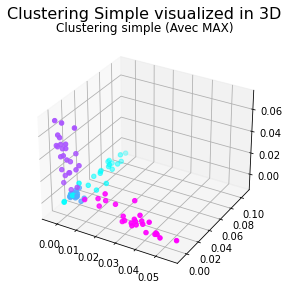

------------------------------------------------------- 
---- plot clusters 
------------------------------------------------------- 


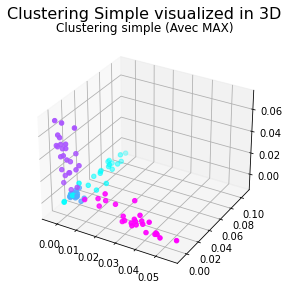

------------------------------------------------------- 
---- plot clusters 
------------------------------------------------------- 


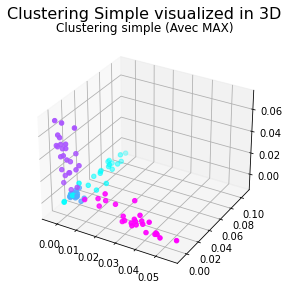

In [67]:
plot_clusters3D(np.transpose(H_test), labels_test, IV_NMF_2D_H_TEST_PNG)
plot_clusters3D(np.transpose(H_test), labels_test, IV_NMF_2D_H_TEST_JPG)
plot_clusters3D(np.transpose(H_test), labels_test, IV_NMF_2D_H_TEST_PDF)

<strong>| Définition de la fonction <a href="#plot_clusters3D"> plot_clusters3D</a> |</strong>

<i>- 2D</i>

------------------------------------------------------- 
---- plot clusters 
------------------------------------------------------- 


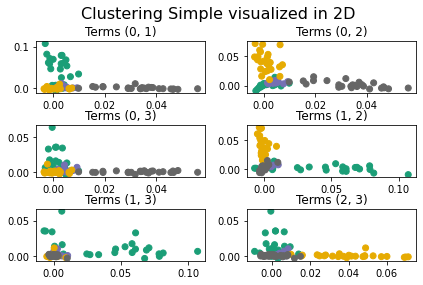

------------------------------------------------------- 
---- plot clusters 
------------------------------------------------------- 


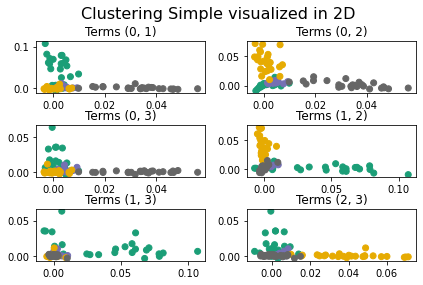

------------------------------------------------------- 
---- plot clusters 
------------------------------------------------------- 


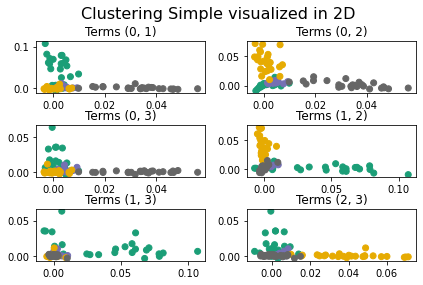

In [68]:
plot_clusters2D(np.transpose(H_test), labels_test, IV_NMF_3D_H_TEST_PNG)
plot_clusters2D(np.transpose(H_test), labels_test, IV_NMF_3D_H_TEST_JPG)
plot_clusters2D(np.transpose(H_test), labels_test, IV_NMF_3D_H_TEST_PDF)

<strong>| Définition de la fonction <a href="#plot_clusters2D"> plot_clusters2D</a> |</strong>

<hr>
<div style="display: flex;">
    <div style="margin: 10px;"><strong><a href="./III-Clustering simple.ipynb">précédent</a></strong></div>
    <div style="margin: 10px;"><strong><a href="./V-Orthogonal NMF.ipynb">suivant</a></strong></div>
</div>